In [2]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt
from functools import reduce
from src.processing.detect_stage import detect_stage


In [15]:
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-83_date-20250718/behav/2025-07-18T13-50-20') # quintuples
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-69_date-20250630/behav/2025-06-30T14-03-21') # triples
# root = Path('/Volumes/harris/hypnose/rawdata/sub-020_id-072/ses-05_date-20250319/behav/2025-03-19T15-00-00')
root = Path('/Volumes/harris/hypnose/rawdata/sub-025_id-076/ses-88_date-20250723/behav/2025-07-23T10-55-40')
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-88_date-20250723/behav/2025-07-23T13-58-16')
stage = detect_stage(root)

/Volumes/harris/hypnose/rawdata/sub-025_id-076/ses-88_date-20250723/behav/2025-07-23T10-55-40/SessionSettings/SessionSettings_*.jsonl
/Volumes/harris/hypnose/rawdata/sub-025_id-076/ses-88_date-20250723/behav/2025-07-23T10-55-40/Schema/Schema_*.jsonl
Found sequence name: FreeRun_Stage5


In [16]:
# Load relevant data streams
behavior_reader = harp.create_reader('device_schemas/behavior.yml', epoch=harp.REFERENCE_EPOCH)
olfactometer_reader = harp.create_reader('device_schemas/olfactometer.yml', epoch=harp.REFERENCE_EPOCH)

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
# # olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
# analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
# flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
# # heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# # 'other' events
# video_reader = utils.Video()
# video_data = utils.load_video(video_reader, root/"VideoData")
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior")
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior")

odour_led = utils.concat_digi_events(output_clear['DOPort0'], output_set['DOPort0'])


In [17]:
# Load heartbeat 
try:
    heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")
except Exception as e:
    print(f"Error loading timestamp data: {e}")
    heartbeat = pd.DataFrame(columns=['Time', 'TimestampSeconds'])

# Reset indices for non-empty dataframes
if not heartbeat.empty:
    heartbeat.reset_index(inplace=True)


In [18]:
# Timestamp conversions
real_time_offset = pd.Timedelta(0)
if not heartbeat.empty and 'Time' in heartbeat.columns and len(heartbeat) > 0:
    try:
        real_time_str = root.name
        match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str)
        if match:
            real_time_str = match.group(0)
        else:
            # Try parent directory
            real_time_str = root.parent.name
            match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str)
            if match:
                real_time_str = match.group(0)
        
        if re.match(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str):
            real_time_ref_utc = datetime.datetime.strptime(real_time_str, '%Y-%m-%dT%H-%M-%S')
            real_time_ref_utc = real_time_ref_utc.replace(tzinfo=datetime.timezone.utc)
            uk_tz = zoneinfo.ZoneInfo("Europe/London")
            real_time_ref = real_time_ref_utc.astimezone(uk_tz)
            
            start_time_hardware = heartbeat['Time'].iloc[0]
            start_time_dt = start_time_hardware.to_pydatetime()
            if start_time_dt.tzinfo is None:
                start_time_dt = start_time_dt.replace(tzinfo=uk_tz)
            real_time_offset = real_time_ref - start_time_dt
    except Exception as e:
        print(f"Error calculating real-time offset: {e}")

# # Apply time offset to non-empty DataFrames
# if not olfactometer_valves_0_abs.empty and 'Time' in olfactometer_valves_0_abs.columns:
#     olfactometer_valves_0_abs['Time'] = olfactometer_valves_0_abs['Time'] + real_time_offset

# Map heartbeat times if we have data
timestamp_to_time = pd.Series()
if not heartbeat.empty and 'Time' in heartbeat.columns and 'TimestampSeconds' in heartbeat.columns:
    heartbeat['Time'] = pd.to_datetime(heartbeat['Time'], errors='coerce')
    timestamp_to_time = pd.Series(data=heartbeat['Time'].values, index=heartbeat['TimestampSeconds'])

def interpolate_time(seconds):
    """Interpolate timestamps from seconds, with safety checks"""
    if timestamp_to_time.empty:
        return pd.NaT
    int_seconds = int(seconds)
    fractional_seconds = seconds % 1
    if int_seconds in timestamp_to_time.index:
        base_time = timestamp_to_time.loc[int_seconds]
        return base_time + pd.to_timedelta(fractional_seconds, unit='s')
    return pd.NaT


In [19]:
# Get experiment events 
experiment_events_dir = root / "ExperimentEvents"

if experiment_events_dir.exists():
    csv_files = list(experiment_events_dir.glob("*.csv"))
    print(f"Found {len(csv_files)} experiment event files")
    
    initiation_sequence_frames = []
    end_initiation_frames = []
    await_reward_frames = []
    reset_frames = []
    choose_random_sequence_frames = []
    sample_reward_condition_frames = []

    for csv_file in csv_files:
        try:
            ev_df = pd.read_csv(csv_file)
            print(f"Processing event file: {csv_file.name} with {len(ev_df)} rows")
            
            # Use Seconds field if available, otherwise use Time field
            if "Seconds" in ev_df.columns and not timestamp_to_time.empty:
                ev_df = ev_df.sort_values("Seconds")#.reset_index(drop=True)
                ev_df["Time"] = ev_df["Seconds"].apply(interpolate_time)
                print(f"Using Seconds column for interpolation")
            else:
                ev_df["Time"] = pd.to_datetime(ev_df["Time"], errors="coerce")
                print(f"Using Time column directly")
            
            if "Time" in ev_df.columns:
                # ev_df["Time"] = ev_df["Time"] + real_time_offset
                
                if "Value" in ev_df.columns:
                    print(f"Found Value column with values: {ev_df['Value'].unique()}")
                    eii_df = ev_df[ev_df["Value"] == "EndInitiation"].copy()
                    if not eii_df.empty:
                        print(f"Found {len(eii_df)} EndInitiation events")
                        eii_df["EndInitiation"] = True
                        end_initiation_frames.append(eii_df[["Time", "EndInitiation"]])

                    is_df = ev_df[ev_df["Value"] == "InitiationSequence"].copy()
                    if not is_df.empty:
                        print(f"Found {len(is_df)} InitiationSequence events")
                        is_df["InitiationSequence"] = True
                        initiation_sequence_frames.append(is_df[["Time", "InitiationSequence"]])

                    rs_df = ev_df[ev_df["Value"] == "Reset"].copy()
                    if not rs_df.empty:
                        print(f"Found {len(rs_df)} Reset events")
                        rs_df["Reset"] = True
                        reset_frames.append(rs_df[["Time", "Reset"]])

                    ar_df = ev_df[ev_df["Value"] == "AwaitReward"].copy()
                    if not ar_df.empty:
                        print(f"Found {len(ar_df)} AwaitReward events")
                        ar_df["AwaitReward"] = True
                        await_reward_frames.append(ar_df[["Time", "AwaitReward"]])

                    src_df = ev_df[ev_df["Value"] == "SampleRewardCondition"].copy()
                    if not src_df.empty:
                        print(f"Found {len(src_df)} SampleRewardCondition events")
                        src_df["SampleRewardCondition"] = True
                        sample_reward_condition_frames.append(src_df[["Time", "SampleRewardCondition"]])

                    crs_df = ev_df[ev_df["Value"] == "ChooseRandomSequence"].copy()
                    if not crs_df.empty:
                        print(f"Found {len(crs_df)} ChooseRandomSequence events")
                        crs_df["ChooseRandomSequence"] = True
                        choose_random_sequence_frames.append(crs_df[["Time", "ChooseRandomSequence"]])
        except Exception as e:
            print(f"Error processing event file {csv_file.name}: {e}")
else:
    print("No ExperimentEvents directory found")

# EndInitiation  
if len(end_initiation_frames) > 0:
    combined_end_initiation_df = pd.concat(end_initiation_frames, ignore_index=True)
    combined_end_initiation_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_end_initiation_df)} EndInitiation events")
else:
    combined_end_initiation_df = pd.DataFrame(columns=["Time", "EndInitiation"])
    print("No EndInitiation events found - cannot identify trial endings")

# AwaitReward
if len(await_reward_frames) > 0:
    combined_await_reward_df = pd.concat(await_reward_frames, ignore_index=True)
    combined_await_reward_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_await_reward_df)} AwaitReward events")
else:
    combined_await_reward_df = pd.DataFrame(columns=["Time", "AwaitReward"])
    print("No AwaitReward events found - cannot identify trial endings")

# InitiationSequence
if len(initiation_sequence_frames) > 0:
    combined_initiation_sequence_df = pd.concat(initiation_sequence_frames, ignore_index=True)
    combined_initiation_sequence_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_initiation_sequence_df)} InitiationSequence events")
else:
    combined_initiation_sequence_df = pd.DataFrame(columns=["Time", "InitiationSequence"])
    print("No InitiationSequence events found - cannot identify trial endings")

# Reset
if len(reset_frames) > 0:
    combined_reset_df = pd.concat(reset_frames, ignore_index=True)
    combined_reset_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_reset_df)} Reset events")
else:
    combined_reset_df = pd.DataFrame(columns=["Time", "Reset"])
    print("No Reset events found - cannot identify trial endings")

# ChooseRandomSequence
if len(choose_random_sequence_frames) > 0:
    combined_choose_random_sequence_df = pd.concat(choose_random_sequence_frames, ignore_index=True)
    combined_choose_random_sequence_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_choose_random_sequence_df)} ChooseRandomSequence events")
else:
    combined_choose_random_sequence_df = pd.DataFrame(columns=["Time", "ChooseRandomSequence"])
    print("No ChooseRandomSequence events found - cannot identify trial endings")

# SampleRewardCondition
if len(sample_reward_condition_frames) > 0:
    combined_sample_reward_condition_df = pd.concat(sample_reward_condition_frames, ignore_index=True)
    combined_sample_reward_condition_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_sample_reward_condition_df)} SampleRewardCondition events")
else:
    combined_sample_reward_condition_df = pd.DataFrame(columns=["Time", "SampleRewardCondition"])
    print("No SampleRewardCondition events found - cannot identify trial endings")


Found 3 experiment event files
Processing event file: ExperimentEvents_1904-01-01T22-00-00.csv with 594 rows
Using Seconds column for interpolation
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence']
Found 99 EndInitiation events
Found 99 InitiationSequence events
Found 99 Reset events
Found 99 AwaitReward events
Found 99 SampleRewardCondition events
Found 99 ChooseRandomSequence events
Processing event file: ExperimentEvents_1904-01-01T20-00-00.csv with 663 rows
Using Seconds column for interpolation
Found Value column with values: ['ChooseRandomSequence' 'SampleRewardCondition' 'InitiationSequence'
 'EndInitiation' 'AwaitReward' 'Reset']
Found 110 EndInitiation events
Found 111 InitiationSequence events
Found 110 Reset events
Found 110 AwaitReward events
Found 111 SampleRewardCondition events
Found 111 ChooseRandomSequence events
Processing event file: ExperimentEvents_1904-01-01T21-00-00.csv wit

In [20]:
combined_end_initiation_df.set_index("Time", inplace=True) 

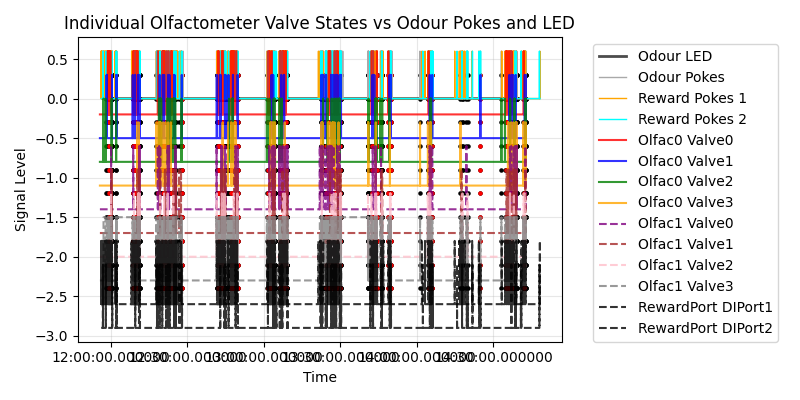

In [21]:
# Plot each individual olfactometer valve state with different colors against pokes
plt.figure(figsize=(8, 4))

event_df = combined_end_initiation_df

# Reward delivery data
pulse_supply_2['PulseSupplyPort2'] = True
pulse_supply_1['PulseSupplyPort1'] = True
        
# Define colors for different valves
valve_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Plot odour LED and pokes first
plt.step(odour_led.index + real_time_offset, odour_led * 0.8, where='post', c='black', linewidth=2, label='Odour LED', alpha=0.7)
plt.step(digital_input_data.index + real_time_offset, digital_input_data['DIPort0'] * 0.6, where='post', c='darkgray', linewidth=1, label='Odour Pokes')
plt.step(digital_input_data.index + real_time_offset, digital_input_data['DIPort1'] * 0.6, where='post', c='orange', linewidth=1, label='Reward Pokes 1')
plt.step(digital_input_data.index + real_time_offset, digital_input_data['DIPort2'] * 0.6, where='post', c='cyan', linewidth=1, label='Reward Pokes 2')

# Plot individual valves from olfactometer 0 and EndInitiation events and reward delivery
valve_offset = -0.2
for i, valve_col in enumerate(olfactometer_valves_0.columns):
        valve_data = olfactometer_valves_0[valve_col]
        color = valve_colors[i % len(valve_colors)]
        plt.step(valve_data.index + real_time_offset, valve_data * 0.8 + valve_offset, where='post', 
                c=color, linewidth=1.5, label=f'Olfac0 {valve_col}', alpha=0.8)
        plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
        plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
        plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
        valve_offset -= 0.3

# Plot individual valves from olfactometer 1 and EndInitiation events and reward delivery
for i, valve_col in enumerate(olfactometer_valves_1.columns):
        valve_data = olfactometer_valves_1[valve_col]
        color = valve_colors[(i + len(olfactometer_valves_0.columns)) % len(valve_colors)]
        plt.step(valve_data.index + real_time_offset, valve_data * 0.8 + valve_offset, where='post', 
                c=color, linewidth=1.5, label=f'Olfac1 {valve_col}', alpha=0.8, linestyle='--')
        plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
        plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
        plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
        valve_offset -= 0.3

# Plot reward pokes and reward delivery
for i, di_col in enumerate(digital_input_data):
        if di_col == 'DIPort1':
                DIPort_data = digital_input_data[di_col]
                plt.step(DIPort_data.index + real_time_offset, DIPort_data * 0.8 + valve_offset, where='post', 
                c='black', linewidth=1.5, label=f'RewardPort {di_col}', alpha=0.8, linestyle='--')
                plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
                plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
                plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
                valve_offset -= 0.3

        elif di_col == 'DIPort2':
                DIPort_data = digital_input_data[di_col]
                plt.step(DIPort_data.index + real_time_offset, DIPort_data * 0.8 + valve_offset, where='post', 
                c='black', linewidth=1.5, label=f'RewardPort {di_col}', alpha=0.8, linestyle='--')
                plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
                plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
                plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
                valve_offset -= 0.3

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))

plt.xlabel('Time')
plt.ylabel('Signal Level')
plt.title('Individual Olfactometer Valve States vs Odour Pokes and LED')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Combine dataframes

In [16]:
# Load olfactometer events
olfactometer_reader = harp.create_reader('device_schemas/olfactometer.yml', epoch=harp.REFERENCE_EPOCH)

try:
    olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
except ValueError:
    print("Olfactometer 0 data could not be loaded")
    olfactometer_valves_0 = pd.DataFrame(columns=['Time', 'Valve0', 'Valve1', 'Valve2', 'Valve3'])

try:
    olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
    olfactometer_valves_1 = olfactometer_valves_1.rename(columns={
        'Valve0': 'Valve4',
        'Valve1': 'Valve5',
        'Valve2': 'Valve6',
        'Valve3': 'Valve7',
    })
except ValueError:
    print("Olfactometer 1 data could not be loaded")
    olfactometer_valves_1 = pd.DataFrame(columns=['Time', 'Valve0', 'Valve1', 'Valve2', 'Valve3'])   

In [ ]:
# # Convert all dataframes to the right format 
# digital_input_data_abs = digital_input_data[['DIPort0', 'DIPort1']].copy() if not digital_input_data.empty else pd.DataFrame()
# olfactometer_valves_0_abs = olfactometer_valves_0.copy() if not olfactometer_valves_0.empty else pd.DataFrame()
# olfactometer_valves_1_abs = olfactometer_valves_1.copy() if not olfactometer_valves_1.empty else pd.DataFrame()
# output_set_abs = output_set[['SupplyPort1', 'SupplyPort2']].copy() if not output_set.empty else pd.DataFrame()

# # Derive real-time offset
# real_time_str = root.as_posix().split('/')[-1]
# real_time_ref_utc = datetime.datetime.strptime(
#     real_time_str, '%Y-%m-%dT%H-%M-%S'
# ).replace(tzinfo=datetime.timezone.utc)
# uk_tz = zoneinfo.ZoneInfo("Europe/London")
# real_time_ref = real_time_ref_utc.astimezone(uk_tz)

# start_time_hardware = heartbeat['Time'].iloc[0]
# start_time_dt = start_time_hardware.to_pydatetime()
# if start_time_dt.tzinfo is None:
#     start_time_dt = start_time_dt.replace(tzinfo=uk_tz)
# real_time_offset = real_time_ref - start_time_dt

# # Make sure all have a 'Time' column and no index conflicts
# for df_abs in [digital_input_data_abs, olfactometer_valves_0_abs, olfactometer_valves_1_abs, output_set_abs, combined_end_initiation_df]:
#     if not df_abs.empty:
#         if df_abs.index.name is not None or df_abs.index.names != [None]:
#             df_abs.reset_index(inplace=True)
#     else:
#         print('Empty dataframe encountered.')

# Combine all events into one dataframe 
# event_frames = []
# event_frames.append(combined_end_initiation_df)
# event_frames.append(digital_input_data_abs)
# event_frames.append(olfactometer_valves_0_abs)
# event_frames.append(olfactometer_valves_1_abs)
# event_frames.append(output_set_abs)

# if event_frames:
#     all_events_df = pd.concat(event_frames, ignore_index=False)

# Merge all dataframes on 'Time'

# dfs_to_merge = [combined_end_initiation_df, digital_input_data_abs, olfactometer_valves_0_abs, olfactometer_valves_1_abs, output_set_abs]
# # Filter out empty dataframes
# dfs_to_merge = [df for df in dfs_to_merge if not df.empty]

# # print(real_time_offset)
# for df_abs in dfs_to_merge:
#     # print(df_abs['Time'])
#     df_abs['Time'] = pd.to_datetime(df_abs['Time'], utc=True, errors='coerce')
#     # df_abs['Time'] = df_abs['Time'] + real_time_offset


# # Merge all on 'Time' (outer join keeps all timestamps, merging by shared times)
# all_events_df = reduce(lambda left, right: pd.merge(left, right, on='Time', how='outer'), dfs_to_merge)

# # Final formatting
# all_events_df.fillna(False, inplace=True) #.infer_objects(copy=False)
# all_events_df.sort_values('Time', inplace=True)
# # all_events_df.rename(columns={'Time': 'timestamp'}, inplace=True)
# all_events_df.reset_index(drop=True, inplace=True)

# print(all_events_df)

44282 days, 16:36:38
                                 Time  EndInitiation  DIPort0  DIPort1  \
0    1904-04-06 19:41:30.348480+00:00          False    False    False   
1    1904-04-06 19:41:30.386496+00:00          False    False    False   
2    1904-04-06 19:42:12.693088+00:00          False    False     True   
3    1904-04-06 19:42:12.727328+00:00          False    False    False   
4    1904-04-06 19:42:12.741568+00:00          False    False     True   
...                               ...            ...      ...      ...   
1028 1904-04-06 22:15:03.408000+00:00          False    False    False   
1029 1904-04-06 22:15:16.995872+00:00          False    False    False   
1030 1904-04-06 22:15:17.103008+00:00          False    False    False   
1031 1904-04-06 22:15:17.115840+00:00          False    False    False   
1032 1904-04-06 22:15:17.330848+00:00          False    False    False   

      Valve0  Valve1  Valve2  Valve3  Valve4  Valve5  Valve6  Valve7  \
0      False   Fal

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_11818/11208691.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_events_df.fillna(False, inplace=True) #.infer_objects(copy=False)


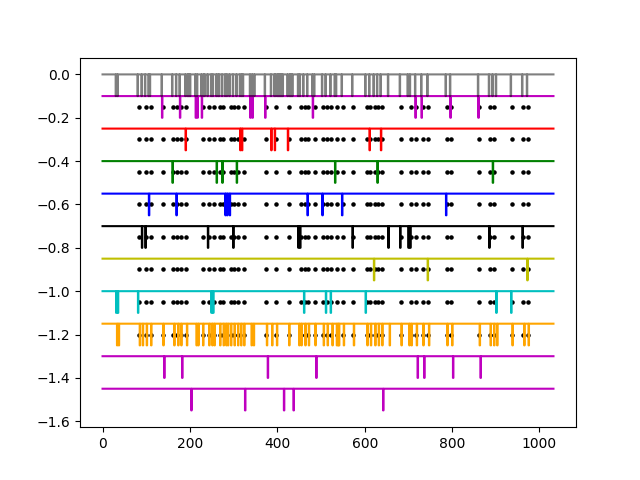

In [28]:
# Plot all events for Freerun 
plt.figure()

# plot odour valve and trial end events
plt.step(all_events_df['Valve0'].index, all_events_df['Valve0'] * -0.1 - 0.1, where='post', c='m') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.15, s=5, c='k')

plt.step(all_events_df['Valve1'].index, all_events_df['Valve1'] * -0.1 - 0.25, where='post', c='r') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.3, s=5, c='k')

plt.step(all_events_df['Valve2'].index, all_events_df['Valve2'] * -0.1 - 0.4, where='post', c='g') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.45, s=5, c='k')

plt.step(all_events_df['Valve3'].index, all_events_df['Valve3'] * -0.1 - 0.55, where='post', c='b') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.6, s=5, c='k')

plt.step(all_events_df['Valve4'].index, all_events_df['Valve4'] * -0.1 - 0.7, where='post', c='k') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.75, s=5, c='k')

plt.step(all_events_df['Valve5'].index, all_events_df['Valve5'] * -0.1 - 0.85, where='post', c='y') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.9, s=5, c='k')

plt.step(all_events_df['Valve6'].index, all_events_df['Valve6'] * -0.1 - 1, where='post', c='c') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 2.05, s=5, c='k')

plt.step(all_events_df['Valve7'].index, all_events_df['Valve7'] * -0.1 - 1.15, where='post', c='orange') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 2.2, s=5, c='k')

# plot odour pokes events
plt.step(all_events_df.index, all_events_df['DIPort0'] * -0.1, where='post', c='k', alpha=0.5) # odour port pokes

# plot reward port A pokes
plt.step(all_events_df.index, all_events_df["SupplyPort1"] * -0.1 - 1.3, where='post', c='m') # lick port A pokes

# plot reward port B events
plt.step(all_events_df.index, all_events_df["SupplyPort2"] * -0.1 - 1.45, where='post', c='m') # lick port B pokes 


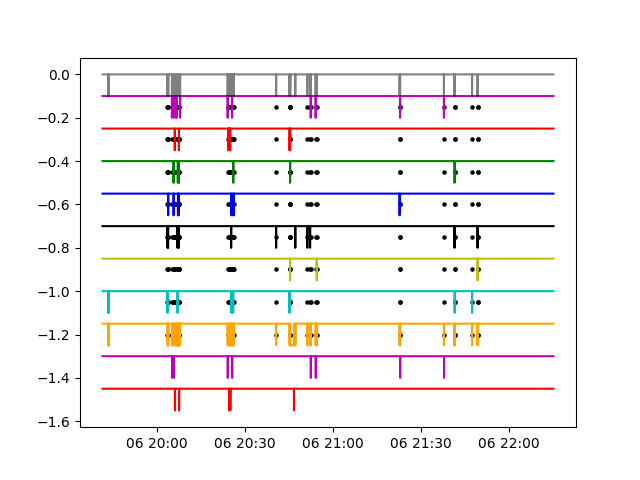

In [ ]:
# Plot all events on time axis for Freerun
# NOTE: The duration of each event is not accurate, because when all dfs are combined, the duration of an
# event is only until the next event occurs, regardless of which df it originally comes from. 

plt.figure()

time = all_events_df['Time']

plt.step(time, all_events_df['Valve0'].astype(int) * -0.1 - 0.1, where='post', c='m')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.15, s=5, c='k')

plt.step(time, all_events_df['Valve1'].astype(int) * -0.1 - 0.25, where='post', c='r')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.3, s=5, c='k')

plt.step(time, all_events_df['Valve2'].astype(int) * -0.1 - 0.4, where='post', c='g')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.45, s=5, c='k')

plt.step(time, all_events_df['Valve3'].astype(int) * -0.1 - 0.55, where='post', c='b')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.6, s=5, c='k')

plt.step(time, all_events_df['Valve4'].astype(int) * -0.1 - 0.7, where='post', c='k')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.75, s=5, c='k')

plt.step(time, all_events_df['Valve5'].astype(int) * -0.1 - 0.85, where='post', c='y')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.9, s=5, c='k')

plt.step(time, all_events_df['Valve6'].astype(int) * -0.1 - 1, where='post', c='c')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -2.05, s=5, c='k')

plt.step(time, all_events_df['Valve7'].astype(int) * -0.1 - 1.15, where='post', c='orange')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -2.2, s=5, c='k')

plt.step(time, all_events_df['DIPort0'].astype(int) * -0.1, where='post', c='k', alpha=0.5)

plt.step(time, all_events_df["SupplyPort1"].astype(int) * -0.1 - 1.3, where='post', c='m') # lick port A pokes

# plot lick port B events
plt.step(time, all_events_df["SupplyPort2"].astype(int) * -0.1 - 1.45, where='post', c='r') # lick port B pokes 


In [ ]:
# Combine olfactometer data frames 
combined_olfactometer_df = [olfactometer_valves_0, olfactometer_valves_1]
# combined_olfactometer_df = reduce(lambda left, right: pd.merge(left, right, on='Time', how='outer'), combined_olfactometer_df)

for df in combined_olfactometer_df:
    df.fillna(False, inplace=True)
    df.sort_values('Time', inplace=True)
    df.reset_index(drop=False, inplace=True)
# combined_olfactometer_df.fillna(False, inplace=True)
# combined_olfactometer_df.sort_values('Time', inplace=True)
# combined_olfactometer_df.reset_index(drop=False, inplace=True)

# Convert timezone and correct for time offset
real_time_str = root.as_posix().split('/')[-1]
real_time_ref_utc = datetime.datetime.strptime(
    real_time_str, '%Y-%m-%dT%H-%M-%S'
).replace(tzinfo=datetime.timezone.utc)
uk_tz = zoneinfo.ZoneInfo("Europe/London")
real_time_ref = real_time_ref_utc.astimezone(uk_tz)

start_time_hardware = heartbeat['Time'].iloc[0]
start_time_dt = start_time_hardware.to_pydatetime()
if start_time_dt.tzinfo is None:
    start_time_dt = start_time_dt.replace(tzinfo=uk_tz)
real_time_offset = real_time_ref - start_time_dt

for df in combined_olfactometer_df:
    df['Time'] = pd.to_datetime(df['Time'], utc=True, errors='coerce') + real_time_offset
# combined_olfactometer_df['Time'] = pd.to_datetime(combined_olfactometer_df['Time'], utc=True, errors='coerce') + real_time_offset
combined_end_initiation_df['Time'] = pd.to_datetime(combined_end_initiation_df['Time'], utc=True, errors='coerce') + real_time_offset


([<matplotlib.axis.YTick at 0x122f9cb90>,
 [Text(0, -0.1, 'A'),
  Text(0, -0.25, 'B'),
  Text(0, -0.4, 'C'),
  Text(0, -0.55, 'D'),
  Text(0, -0.7, 'E'),
  Text(0, -0.85, 'F'),
  Text(0, -1.0, 'G'),
  Text(0, -1.15, 'Purge')])

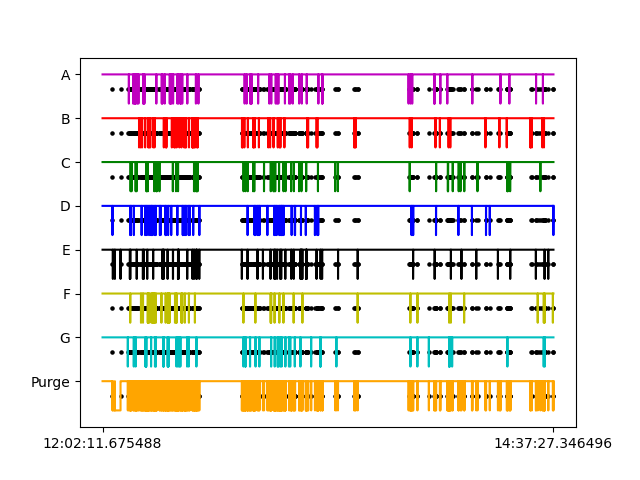

In [20]:
# Plot olfactometer events on time axis for Freerun
# NOTE: Each dataframe events are plotted separately, because this way the plotting of each event 
# lasts until the value of that event turns to False. 

# Plot 
plt.figure()

valves_time0 = combined_olfactometer_df[0]['Time']
valves_time1 = combined_olfactometer_df[1]['Time']
end_initiation_time = combined_end_initiation_df['Time']

plt.step(valves_time0, combined_olfactometer_df[0]['Valve0'].astype(int) * -0.1 - 0.1, where='post', c='m')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -1.15, s=5, c='k')

plt.step(valves_time0, combined_olfactometer_df[0]['Valve1'].astype(int) * -0.1 - 0.25, where='post', c='r')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -1.3, s=5, c='k')

plt.step(valves_time0, combined_olfactometer_df[0]['Valve2'].astype(int) * -0.1 - 0.4, where='post', c='g')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -1.45, s=5, c='k')

plt.step(valves_time0, combined_olfactometer_df[0]['Valve3'].astype(int) * -0.1 - 0.55, where='post', c='b')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -1.6, s=5, c='k')

plt.step(valves_time1, combined_olfactometer_df[1]['Valve4'].astype(int) * -0.1 - 0.7, where='post', c='k')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -1.75, s=5, c='k')

plt.step(valves_time1, combined_olfactometer_df[1]['Valve5'].astype(int) * -0.1 - 0.85, where='post', c='y')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -1.9, s=5, c='k')

plt.step(valves_time1, combined_olfactometer_df[1]['Valve6'].astype(int) * -0.1 - 1, where='post', c='c')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -2.05, s=5, c='k')

plt.step(valves_time1, combined_olfactometer_df[1]['Valve7'].astype(int) * -0.1 - 1.15, where='post', c='orange')
plt.scatter(end_initiation_time, np.ones((len(combined_end_initiation_df), 1)) -2.2, s=5, c='k')

# Fix axes
min_time = np.min([list(valves_time0)[0], list(valves_time1)[0], list(end_initiation_time)[0]])
max_time = np.max([list(valves_time0)[-1], list(valves_time1)[-1], list(end_initiation_time)[-1]])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
plt.xticks([min_time, max_time])

yticks = [-0.1, -0.25, -0.4, -0.55, -0.7, -0.85, -1, -1.15]
plt.yticks(yticks, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Purge'])
